In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from collections import namedtuple
from DecisionTree import DecisionTree

Define a class which makes the splitting decision for a given feature/set of features. This makes it easier to modify the splitting criterion later on, if desired.

In [2]:
class Decision:
    mean = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.mean = X.mean(axis=0)

    def predict(self, X: np.ndarray):
        return X < self.mean

The main Decision Tree class. The algorithm is very simple:
- While stopping criteria are not satisfied
    - For each feature, calculate the information gain obtained by splitting it into two sets based on the above decision function. Select the feature with maximum information gain as the best feature for the iteration.
    - Split the data based on the feature. For each of the data obtained in the split, repeat the above step until the stoppind criteria are not satisfied
- Stopping criteria I've chosen include:
    - Maximum number of levels in the tree.
    - All points belonging to the same class in a node
    - Only a single point remaining in a node

In [3]:
class DecisionTree:
    decisions = None
    max_level = None
    Node = None
    m = None

    def __init__(self, max_level=10, m=2):
        self.Node = namedtuple('Node', ['function', 'feature', 'target_data'])
        self.decisions = {}
        self.max_level = max_level
        self.m = m

    def fit(self, X, y):
        split_data = {'h': (X, y)}
        if self.max_level == -1:
            self.max_level = X.shape[0]
        if self.m is None:
            self.m = X.shape[1]
        for level in range(self.max_level):
            # print("Level {0}: dict: {1}".format(level, split_data))
            split_data_ = {}
            for key in split_data:
                data, targets = split_data[key]
                if self.stopping_criteria(data, targets):
                    self.decisions[key] = self.Node(None, None, targets)
                    continue  # Data will not be split because stopping criteria are met
                gains = []
                features = np.arange(X.shape[1])
                np.random.shuffle(features)
                features = features[:self.m]
                for feature in features:
                    d = Decision()
                    d.fit(data[:, feature], targets)
                    split_indices = d.predict(data[:, feature])
                    gains.append(self.information_gain(targets, split_indices))
                best_feat_ind = np.argmax(np.asarray(gains))
                self.decisions[key] = self.Node(Decision(), best_feat_ind, targets)
                self.decisions[key].function.fit(data[:, best_feat_ind], targets)
                split_indices = self.decisions[key].function.predict(data[:, best_feat_ind])
                if data[split_indices].shape[0] != 0:
                    split_data_[key + 'l'] = (data[split_indices], targets[split_indices])
                if data[~split_indices].shape[0] != 0:
                    split_data_[key + 'r'] = (data[~split_indices], targets[~split_indices])
            if len(split_data_) == 0:
                break  # Tree built to full extent. No need to continue building tree.
            split_data = split_data_

    def predict(self, X):
        y_pred = []
        for point in X:
            key = 'h'
            target_data = None
            while key in self.decisions:
                dec_fn, feat, target_data = self.decisions[key]
                if dec_fn is not None:
                    left = dec_fn.predict(point[feat])
                    if left:
                        key += 'l'
                    else:
                        key += 'r'
                else:
                    break
            y_pred.append(np.argmax(np.bincount(target_data)))

        return np.asarray(y_pred)

    @staticmethod
    def entropy(y):
        classes = np.unique(y)
        p = np.bincount(y)[classes] / y.shape[0]

        return -np.sum(p * np.log2(p))

    def information_gain(self, y: np.ndarray, split_indices: np.ndarray):
        base_entropy = self.entropy(y)
        Sv_S = np.bincount(split_indices) / split_indices.shape[0]
        new_entropy = np.array([self.entropy(y[~split_indices]), self.entropy(y[split_indices])])
        new_entropy *= Sv_S

        return base_entropy - new_entropy.sum()

    @staticmethod
    def stopping_criteria(X, y):
        if X.shape[0] == 1:
            return True  # Single point in leaf
        if np.unique(y).shape[0] == 1:
            return True  # All points are of a single class
        return False

In [4]:
class RandomForest:
    num_trees = None
    m = None
    trees = None
    oob_error = None

    def __init__(self, num_trees=500, m=None, max_level=-1):
        self.num_trees = num_trees
        self.m = m
        self.trees = []
        for tree in range(self.num_trees):
            self.trees.append(DecisionTree(max_level, self.m))

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.m = int(sqrt(X.shape[1])) if self.m is None else self.m
        num_points = X.shape[0]
        train_ind = np.random.randint(0, num_points, size=(self.num_trees, num_points))
        oob_ind = []
        oob_preds = pd.DataFrame()
        for row in range(self.num_trees):
            oob_ind.append(np.setdiff1d(np.arange(X.shape[0]), train_ind[row]))
        for ind, tree in enumerate(self.trees):
            tree.fit(X[train_ind[ind]], y[train_ind[ind]])
            oob_pred = tree.predict(X[oob_ind[ind]])
            oob_preds[ind] = pd.Series(oob_pred, index=oob_ind[ind])
        votes = oob_preds.apply(pd.value_counts, axis=1)
        y_pred = votes.idxmax(axis=1)
        y_true = y[votes.index]
        from sklearn.metrics import accuracy_score
        self.oob_error = 1 - accuracy_score(y_true, y_pred)

    def predict(self, X: np.ndarray):
        oob_preds = pd.DataFrame()
        for ind, tree in enumerate(self.trees):
            oob_pred = tree.predict(X)
            oob_preds[ind] = pd.Series(oob_pred, index=np.arange(X.shape[0]))
        votes = oob_preds.apply(pd.value_counts, axis=1)
        return votes.idxmax(axis=1)

In [5]:
path_to_data = '../Data/wine.data'
data = np.genfromtxt(path_to_data, delimiter=',')
X, y = data[:, 1:], data[:, 0].astype(np.int8)

In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
from sklearn.metrics import accuracy_score

max_num_trees = 500
train_error_full, test_error_full, oob_error_full = [], [], []
train_error_small, test_error_small, oob_error_small = [], [], []
for b in range(1, max_num_trees, 5):
    rf_full = RandomForest(num_trees=b)
    rf_small = RandomForest(num_trees=b, max_level=5)
    rf_full.fit(X_train, y_train)
    rf_small.fit(X_train, y_train)
    train_error_full.append(1-accuracy_score(y_train, rf_full.predict(X_train)))
    train_error_small.append(1-accuracy_score(y_train, rf_small.predict(X_train)))
    test_error_full.append(1-accuracy_score(y_test, rf_full.predict(X_test)))
    test_error_small.append(1-accuracy_score(y_test, rf_small.predict(X_test)))
    oob_error_full.append(rf_full.oob_error)
    oob_error_small.append(rf_small.oob_error)

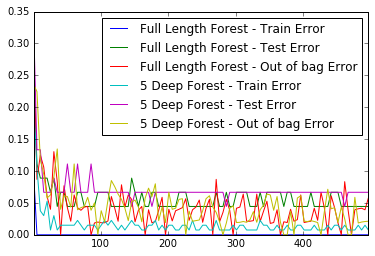

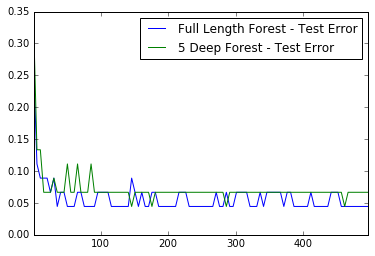

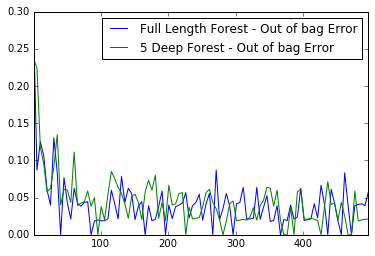

In [13]:
metrics = pd.DataFrame()
metrics['Full Length Forest - Train Error'] = train_error_full
metrics['Full Length Forest - Test Error'] = test_error_full
metrics['Full Length Forest - Out of bag Error'] = oob_error_full
metrics['5 Deep Forest - Train Error'] = train_error_small
metrics['5 Deep Forest - Test Error'] = test_error_small
metrics['5 Deep Forest - Out of bag Error'] = oob_error_small
metrics.index = np.arange(1, max_num_trees, 5)

metrics.plot()
metrics[['Full Length Forest - Test Error', '5 Deep Forest - Test Error']].plot()
metrics[['Full Length Forest - Out of bag Error', '5 Deep Forest - Out of bag Error']].plot()

The error starts plateauing at around b = 30. This would be a good choice for the random forests, but it makes no visible difference to use b = 500 either.

The overall error is comparable to both the classifiers, where as the training error is lesser for the full length forest. This is because the full length forest "memorizes" the data and overfits.

In [7]:
from sklearn.metrics import confusion_matrix

rf_full = RandomForest(num_trees=50)
rf_small = RandomForest(num_trees=50, max_level=5)
rf_full.fit(X_train, y_train)
rf_small.fit(X_train, y_train)

y_pred_full, y_pred_small = rf_full.predict(X_test), rf_small.predict(X_test)

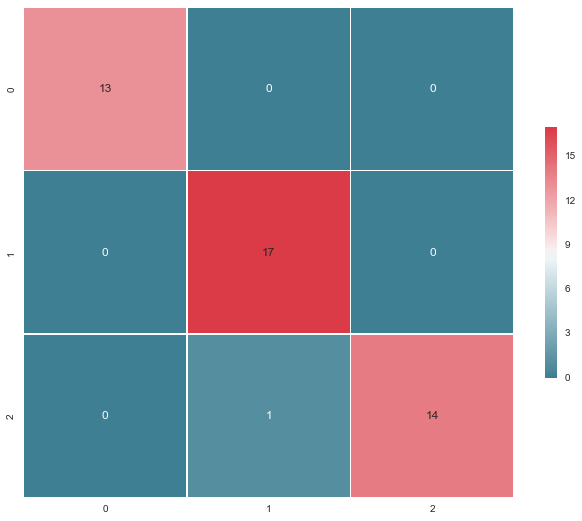

In [8]:
f1, ax1 = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_full), columns=[0,1,2], index=[0,1,2])
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_mat, cmap=cmap, annot=True, fmt='d', square=True, xticklabels=True, yticklabels=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)

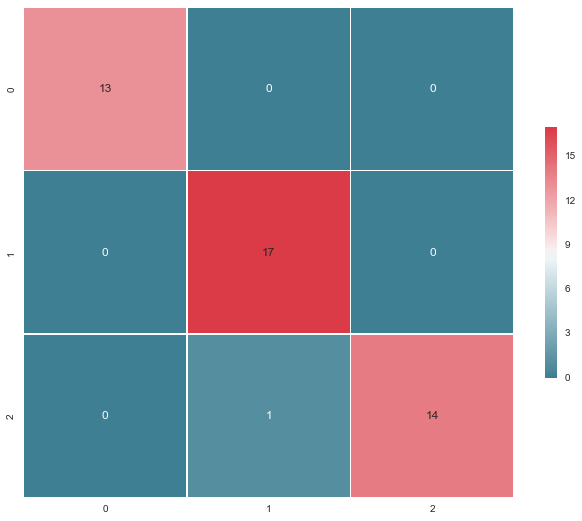

In [9]:
f2, ax2 = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_full), columns=[0,1,2], index=[0,1,2])
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_mat, cmap=cmap, annot=True, fmt='d', square=True, xticklabels=True, yticklabels=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2)

Because the DecisionTree classifier created by me runs slower compared to sklearn's classifier, especially when the number of points to predict are more, I'm using sklearn's version for the MNIST data set only. The below code is the exact same as the above code but with my DecisionTree class replaced by sklearn's version

In [13]:
from sklearn.tree import DecisionTreeClassifier
class RandomForests:
    num_trees = None
    max_level = None
    m = None
    trees = None
    oob_error = None

    def __init__(self, num_trees=500, m=None, max_level=-1):
        self.num_trees = num_trees
        self.m = m
        self.trees = []
        self.max_level = None if max_level == -1 else max_level

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.m = int(sqrt(X.shape[1])) if self.m is None else self.m
        for tree in range(self.num_trees):
            self.trees.append(DecisionTreeClassifier(max_features=self.m, max_depth=self.max_level))
        num_points = X.shape[0]
        train_ind = np.random.randint(0, num_points, size=(self.num_trees, num_points))
        oob_ind = []
        oob_preds = pd.DataFrame()
        for row in range(self.num_trees):
            oob_ind.append(np.setdiff1d(np.arange(X.shape[0]), train_ind[row]))
        for ind, tree in enumerate(self.trees):
            tree.fit(X[train_ind[ind]], y[train_ind[ind]])
            oob_pred = tree.predict(X[oob_ind[ind]])
            oob_preds[ind] = pd.Series(oob_pred, index=oob_ind[ind])
        votes = oob_preds.apply(pd.value_counts, axis=1)
        y_pred = votes.idxmax(axis=1)
        y_true = y[votes.index]
        from sklearn.metrics import accuracy_score
        self.oob_error = 1 - accuracy_score(y_true, y_pred)

    def predict(self, X: np.ndarray):
        oob_preds = pd.DataFrame()
        for ind, tree in enumerate(self.trees):
            oob_pred = tree.predict(X)
            oob_preds[ind] = pd.Series(oob_pred, index=np.arange(X.shape[0]))
        votes = oob_preds.apply(pd.value_counts, axis=1)
        return votes.idxmax(axis=1)

In [14]:
mnist_data = np.genfromtxt('../Data/MNIST_HW1/train.csv', delimiter=',', dtype=np.float)
mnist_data = mnist_data.T
X_train = mnist_data[:, :-1]
y_train = mnist_data[:, -1].astype(int)

In [15]:
mnist_test_data = np.genfromtxt('../Data/MNIST_HW1/test.csv', delimiter=',', dtype=np.float)
mnist_test_data = mnist_test_data.T
X_test = mnist_test_data[:, :-1]
y_test = mnist_test_data[:, -1].astype(int)

In [34]:
from sklearn.metrics import accuracy_score

max_num_trees = 500
train_error_full, test_error_full, oob_error_full = [], [], []
train_error_small, test_error_small, oob_error_small = [], [], []
param_range = list(range(1, 100, 10))
param_range.extend([200, 300, 400, 500])
for b in param_range:
    rf_full = RandomForests(num_trees=b)
    rf_small = RandomForests(num_trees=b, max_level=5)
    rf_full.fit(X_train, y_train)
    rf_small.fit(X_train, y_train)
    train_error_full.append(1-accuracy_score(y_train, rf_full.predict(X_train)))
    train_error_small.append(1-accuracy_score(y_train, rf_small.predict(X_train)))
    test_error_full.append(1-accuracy_score(y_test, rf_full.predict(X_test)))
    test_error_small.append(1-accuracy_score(y_test, rf_small.predict(X_test)))
    oob_error_full.append(rf_full.oob_error)
    oob_error_small.append(rf_small.oob_error)

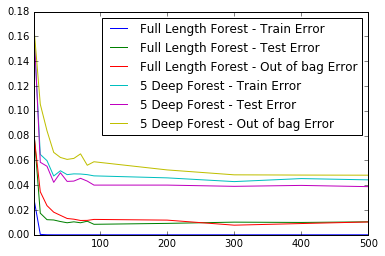

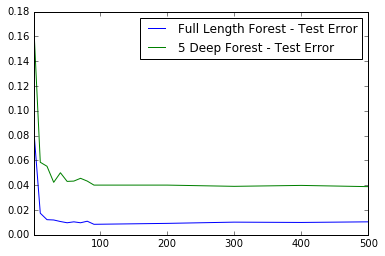

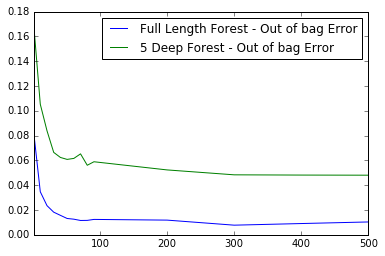

In [36]:
metrics = pd.DataFrame()
metrics['Full Length Forest - Train Error'] = train_error_full
metrics['Full Length Forest - Test Error'] = test_error_full
metrics['Full Length Forest - Out of bag Error'] = oob_error_full
metrics['5 Deep Forest - Train Error'] = train_error_small
metrics['5 Deep Forest - Test Error'] = test_error_small
metrics['5 Deep Forest - Out of bag Error'] = oob_error_small
metrics.index = param_range

metrics.plot()
metrics[['Full Length Forest - Test Error', '5 Deep Forest - Test Error']].plot()
metrics[['Full Length Forest - Out of bag Error', '5 Deep Forest - Out of bag Error']].plot()

The full length forest performs much better in this case compared to 5 deep forest in this case. Because the data is much more complex the overfitting is slightly lesser in this case. A forest of depth 5 is too simple a model for this data. 

In [ ]:
from sklearn.metrics import confusion_matrix

rf_full = RandomForests(num_trees=80)
rf_small = RandomForests(num_trees=80, max_level=5)
rf_full.fit(X_train, y_train)
rf_small.fit(X_train, y_train)

#### Full length forest

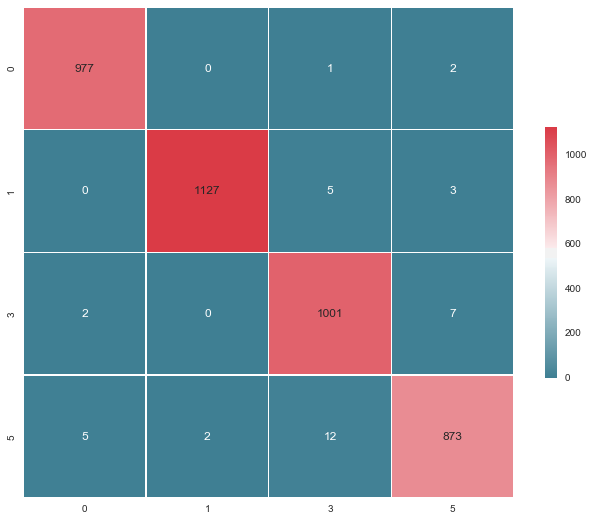

In [41]:
f4, ax4 = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_full), columns=[0,1,3,5], index=[0,1,3,5])
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_mat, cmap=cmap, annot=True, fmt='d', square=True, xticklabels=True, yticklabels=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax4)

#### Forest with max depth 5

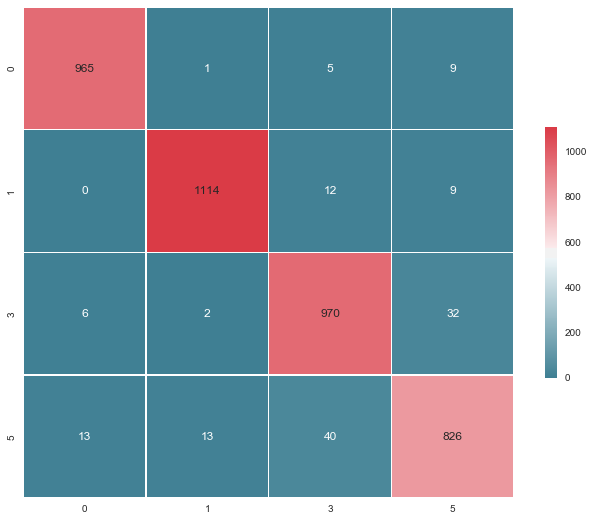

In [43]:
f4, ax4 = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_small), columns=[0,1,3,5], index=[0,1,3,5])
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_mat, cmap=cmap, annot=True, fmt='d', square=True, xticklabels=True, yticklabels=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax4)

Random forests are much less prone to overfitting compared to decision trees. They are generally very robust and generalize well, so a good idea to model with random forests would be to create a forest with as complex a base classifier as possible. This is in stark contrast to the AdaBoost classifier where it is more advantageous to fit simple classifiers to the data in each iteration. AdaBoost is much more prone to overfitting, especially when the base classifier is complex. Where as random forests incorporate greater generality into the model with increasing number of trees, AdaBoost improves its confidence of classification with each iteration.